# KIT315 Tutorial-3 (Week 4) 
# Machine Learning for Fintech

## A. Environment Setup

For practicing Machine Learning, you can use the lab computers or install the following packages/libraries in your personal computer.

- Python 3.8

- Numpy 

- Scikit-Learn

- Matplotlib


## B. Insurance Charge Prediction

In this tutorial, we will predict the insurance charges from personal information, such as  age, sex, (body mass index) bmi, number of children, smoking, and living region.

#### Step 1

Download the insurance.csv file. Let's store the data in insurance_data directory (if the data is saved in another location, please change the code accordingly). Different from the format of the CSV file we worked in the classification tutorial, this CSV has column names. Therefore, it will be easier to use pandas to load the data, the format of the data in pandas is Data Frame.

In [1]:
import pandas as pd

Load the data and show some samples.

In [2]:
data = pd.read_csv('datasets/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


- age: age of the primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

Let us explore the distribution of the binomial features (sex, smoker, and region).

(array([325.,   0.,   0., 364.,   0.,   0., 325.,   0.,   0., 324.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

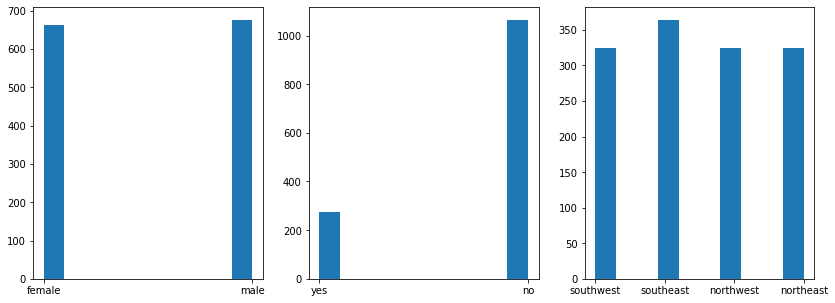

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,5))
ax1.hist(data['sex'])
ax2.hist(data['smoker'])
ax3.hist(data['region'])

As we can see sex and smoker are binary attributes, regions is  a nominal attribute. We will need to convert them into numberical as follows:

sex - 1-level encoder with male=0, female=1

smoker - 1-level encoder with no=0, yes=1 

region - 4-level one-hot encoder

  northeast - 1000

  northwest - 0100
  
  southeast - 0010

  southwest - 0001

Let us encode sex and smoker first. Run the code below and see the new values of these attributes.

In [4]:
from sklearn import preprocessing
sexSmokerEncoder = preprocessing.OrdinalEncoder(categories=[['male','female'],['no','yes']],dtype=int)
data[['sex','smoker']] = sexSmokerEncoder.fit_transform(data[['sex','smoker']])
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


Now, we encode the region attribute by creating new four attributes to represent the one-hot values of the four regions.

In [5]:
data[['NE','NW','SE','SW']] = pd.get_dummies(data['region'], prefix=None)
data.drop(columns=['region'],inplace=True)
data.head()

,age,sex,bmi,children,smoker,charges,NE,NW,SE,SW
0,19,1,27.900,0,1,16884.92400,0,0,0,1
1,18,0,33.770,1,0,1725.55230,0,0,1,0
2,28,0,33.000,3,0,4449.46200,0,0,1,0
3,33,0,22.705,0,0,21984.47061,0,1,0,0
4,32,0,28.880,0,0,3866.85520,0,1,0,0


#### Step 2

Similar to the step 2 in classification, this step split the attributes into input features and class.

In [6]:
fnames = [name for name in list(data.columns) if name !="charges"]
x = data[fnames].to_numpy()    # convert to numpy array
y = data["charges"].to_numpy() # convert to numpy array

#### Step 3 and Step 4

In this task, we will learn another evaluation method using train, validation, and test sets where the validation set will be used to select a good combination of hyper-parameters. We will combine two steps (normalisation and setting up the training and evaluation) so we can properly normalise the data. First, split the data into train, validation, and test sets.

In [7]:
from sklearn.model_selection import train_test_split

x_trainval, x_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval,y_trainval,test_size=0.25)

print("Number of sample for train: %d, validation: %d, test: %d"%(x_train.shape[0],x_val.shape[0],x_test.shape[0]))

Number of sample for train: 802, validation: 268, test: 268


We will normalise  the training data and then use the scaler (from the training set) to normalise the validation and test. This makes the evaluation fairer as we need to treat validation set and test set as unseen data.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
x_train_norm = scaler.fit_transform(x_train)
x_val_norm = scaler.transform(x_val) # See the difference herer (no fit)
x_test_norm = scaler.transform(x_test)

We will follow the model selection section in the classification task to define a function for a grid search. However, different from the grid search in the classification task in the previous lecture, in this case we don't use cross validation with K folds. Instead we only have 1 fold with the training set for training and the validation set for validation. First, we combine the training set and the validation set, then we set the indices of the validation samples as the test_fold (validation fold in our terms). 

We also, change the scoring to "neg_mean_absolute_error" as we are doing regression. In the future, if you do other tasks, please refer to here https://scikit-learn.org/stable/modules/model_evaluation.html to find a suitable scoring name.

In [9]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

def grid_search(model, grid_params):
    # Combine the train, and val dataset together
    all_inputs = np.append(x_train_norm,x_val_norm,axis=0)
    all_labels = np.append(y_train,y_val)
    # define the val part in all_inputs is for validation
    val_inds = [-1]*x_train_norm.shape[0] + [0]*x_val_norm.shape[0]
    ps   = PredefinedSplit(test_fold=val_inds)
    # employ Grid Search with cross validation, but now there is only 1 fold with the val part is for validation
    grid = GridSearchCV(model, grid_params,cv=ps, scoring="neg_mean_absolute_error",refit = True, verbose = 3,n_jobs=-1) 
   
    # fitting the model for grid search 
    grid.fit(all_inputs, all_labels) 
 
    return grid

#### Step 5

Now, let's test with Linear Regression. We perform grid search on two hyper-parameters: fit_intercept and normalize.

In [10]:
# We can go here
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# to check the hyper-params of linear regress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
#fit_intercept=True, normalize=False, copy_X=True, n_jobs=None, positive=False)

linrgr = LinearRegression()
param_grid = {'fit_intercept': [True,False],  
              'normalize': [False,True]} 

grid = grid_search(linrgr,param_grid)
print(grid.best_params_) 
print(grid.best_score_)

# apply to the test
pred = grid.predict(x_test) 
mse_test = mean_absolute_error(y_true=y_test,y_pred=pred)

print("Mean absolute error %.5f" %(mse_test))

Fitting 1 folds for each of 4 candidates, totalling 4 fits
{'fit_intercept': True, 'normalize': False}
-4118.331174266097
Mean absolute error 821761.76563


c:\Users\billz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


You can always find other models in https://scikit-learn.org/. In the code below, we use RandomForestRegressor

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import RandomForestRegressor

rfr  = RandomForestRegressor()
param_grid = {'n_estimators': [5,10,100,500]} 

grid = grid_search(rfr,param_grid)
print(grid.best_params_) 
print(grid.best_score_)

# apply to the test
pred = grid.predict(x_test) 
mse_test = mean_absolute_error(y_true=y_test,y_pred=pred)

print("Mean absolute error %.5f" %(mse_test))

Fitting 1 folds for each of 4 candidates, totalling 4 fits
{'n_estimators': 500}
-2680.319749663597
Mean absolute error 11846.04664


Now you can see which model has a better performance on the test set.

# Exercise: Cryptocurrency Price Prediction

In this exercise we will predict crytocurrency prices. We have six datasets for bitcoin, ethereum, tether, cardano, ripple,and dogecoin. First, let's load the data for "bitcoin". You can modify the code to load the data for the other cryptocurrencies. 

In [12]:
import pandas as pd
data = pd.read_csv("./fintech/bitcoin.csv")
data.head()

,Unnamed: 0,symbol,date,open,high,low,close,volume,market,name,ranknow
0,0,BTC,2013-04-28,135.30,135.98,132.10,134.21,0,1500520000,Bitcoin,1
1,1,BTC,2013-04-29,134.44,147.49,134.00,144.54,0,1491160000,Bitcoin,1
2,2,BTC,2013-04-30,144.00,146.93,134.05,139.00,0,1597780000,Bitcoin,1
3,3,BTC,2013-05-01,139.00,139.89,107.72,116.99,0,1542820000,Bitcoin,1
4,4,BTC,2013-05-02,116.38,125.60,92.28,105.21,0,1292190000,Bitcoin,1


As we can see, the data gives us the information about the open price, high price, low price, and close price of a day of a cryptocurrancy. We will predict the close price. The changes of the close prices can be plotted using the following code.

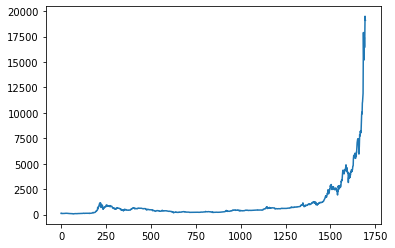

In [13]:
import matplotlib.pyplot as plt
data = data.to_numpy()
plt.plot(data[:,6])

We will predict the close price of a cryptocurrency using the  open price, high price, low price, and close price of N previous days.

In [14]:
from toolkit import prepare_data
# 3,4,5,6 are indices of the open price, high price, low price, and close price of N-1 previous days
# 6 is the index of the close price to predict
x,y = prepare_data(data,[3,4,5,6],6,N=5)

### Task 01:  Partition the data to use 65% of the data for training and the rest for testing.

#### Fill in the question mark in the code

In [15]:
# TO COMPLETE
DATA_SIZE  = data.shape[0]
TRAIN_SIZE = int(DATA_SIZE*0.65)
train_x = x[:TRAIN_SIZE,:]
test_x  = x[TRAIN_SIZE:,:]
train_y = y[:TRAIN_SIZE]
test_y  = y[TRAIN_SIZE:]

### Task 02: Select a good model

Using an appropriate method to select a good model using diffent approaches: Elastic Nets, SVR, RandomForestRegressor. GridSearchCV is recommended.

NOTE: For saving time, please use a narrow grid search for model selection.

In [16]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def grid_search(model, grid_params):
    grid = GridSearchCV(model, grid_params, cv=5, scoring="neg_mean_squared_error", refit=True, verbose=3, n_jobs=-1)
    
    grid.fit(train_x, train_y)
    print(grid.best_params_)
    print(grid.best_score_)

    # predict and see performance
    pred = grid.predict(test_x)
    mse = mean_squared_error(test_y, pred)
    print("mean squared error is %.5f" % (mse))
    
    return grid

In [17]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Elastic Net
param_grid_elastic = {
    'alpha': [1, 5],
    'l1_ratio': [0.5, 0.95],
    'max_iter': [1000, 3000]
}
print("Elastic Net: ")
grid_search(ElasticNet(), param_grid_elastic)

Elastic Net: 
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 5, 'l1_ratio': 0.95, 'max_iter': 3000}
-613.3124406622549
mean squared error is 64669.59523


c:\Users\billz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+05, tolerance: 4.363e+03
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1, 5], 'l1_ratio': [0.5, 0.95],
                         'max_iter': [1000, 3000]},
             scoring='neg_mean_squared_error', verbose=3)

In [18]:
# SVR
param_grid_SVR = {
    'kernel': ['linear'], # rbf is disaster
    'C': [0.001, 0.0015, 0.002, 0.0025],
}
print("SVR: ")
grid_search(SVR(), param_grid_SVR)

SVR: 
Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'C': 0.0025, 'kernel': 'linear'}
-600.1515035227882
mean squared error is 63789.68242


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.0015, 0.002, 0.0025],
                         'kernel': ['linear']},
             scoring='neg_mean_squared_error', verbose=3)

In [19]:
# Random Forest Regressor
param_grid_RandomForest = {
    'n_estimators': [100, 200],
    'min_samples_leaf': [1, 3, 5],
}

print("RandomForestRegressor: ")
grid_search(RandomForestRegressor(), param_grid_RandomForest)

RandomForestRegressor: 
Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'min_samples_leaf': 3, 'n_estimators': 100}
-2634.5965731750875
mean squared error is 11218087.67098


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=3)

Report the results

Elastic Net: 
    - Best params: {'alpha': 5, 'l1_ratio': 0.95, 'max_iter': 3000}
    - Best score : -613.3124406622549
    - Test MSE   : 64669.59523
    

SVR: 
    - Best params: {'C': 0.0025, 'kernel': 'linear'}
    - Best score : -600.1515035227882
    - Test MSE   : 63789.68242
    
RandomForestRegressor: 
    - Best params: {'min_samples_leaf': 3, 'n_estimators': 100}
    - Best score : -2634.5965731750875
    - Test MSE   : 11218087.67098
  

### Task 03: Report the best model

Complete the code below with the best model and run the report function to generate the visualisation of the prediction of the best model.

NOTE: Please feel free to modify the code to make it work.

In [20]:
model = SVR(kernel='linear', C=0.0025)
model.fit(train_x,train_y)
pred = model.predict(test_x)

In [21]:
from sklearn.metrics import mean_squared_error 
def report(test_y,pred):
    mse = mean_squared_error(test_y,pred)
    print("Mean square error: %f"%(mse))
    plt.subplot(1,2,1)
    plt.scatter(pred,test_y)
    plt.xlabel("Predicted prices")
    plt.ylabel("Actual prices")
    plt.subplot(1,2,2)
    plt.plot(pred)
    plt.plot(test_y)

Mean square error: 63789.682423


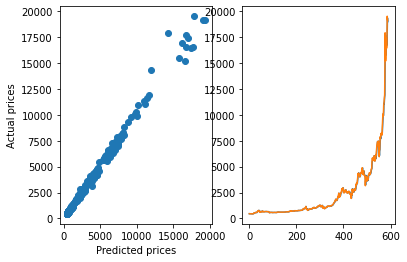

In [22]:
report(test_y,pred)